## Setup Example

In [12]:
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/My Drive')

!pip3 install tensorboardX


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
     |████████████████████████████████| 204kB 2.8MB/s 


In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd.variable import Variable
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import imageio
from utils import Logger
...


Ellipsis

## Dataset
To simplify, the PyTorch MNIST wrapper, which downloads and loads the MNIST dataset. See the [documentation](https://github.com/pytorch/vision/blob/master/torchvision/datasets/mnist.py) for more information about the interface. The default parameters will take 5,000 of the training examples and place them into a validation dataset. The data will be saved into a folder called `MNIST_data`. 

In [14]:
batch_size = 56 #number of training examples
transform_data = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[0.5], std=[0.5])])

mnist_data = MNIST(root='./MNIST_data', train=True, download=True, transform=transform_data) 
data_loader = DataLoader(dataset=mnist_data, shuffle=True, batch_size=batch_size)


Extracting ./MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST_data/MNIST/raw


Extracting ./MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST_data/MNIST/raw




Extracting ./MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST_data/MNIST/raw


Extracting ./MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST_data/MNIST/raw
Processing...
Done!


## Random Noise
Generate uniform noise from -1 to 1 with shape `[batch_size, dim]`. Implement `sample_noise` Hint: use `torch.rand`. Make sure noise is the correct shape and type:

In [0]:
def sample_noise(batch_size, dim): 
    return torch.rand(batch_size, dim) + torch.rand(batch_size, dim)*(-1)
 

# Discriminator
Our first step is to build a discriminator. Fill in the architecture: A three hidden-layer discriminative neural network.
 * Fully connected layer 
 * LeakyReLU 
 * Fully connected layer 
 * LeakyReLU 
 * Fully connected layer 

In [16]:
class DiscriminatorNet(torch.nn.Module):

    def __init__(self):
        super(DiscriminatorNet, self).__init__()
        input_size = 784 #28x28
        DfirstHiddenLayer_size = 1024
        DsecondHiddenLayer_size = 512
        DthirdHiddenLayer_size = 256
        
        output_size = 1
        
        self.firstHiddenLayer = nn.Sequential( 
            nn.Linear(input_size, DfirstHiddenLayer_size),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.secondHiddenLayer = nn.Sequential(
            nn.Linear(DfirstHiddenLayer_size, DsecondHiddenLayer_size),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.thirdHiddenLayer = nn.Sequential(
            nn.Linear(DsecondHiddenLayer_size, DthirdHiddenLayer_size),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.outputLayer = nn.Sequential(
            torch.nn.Linear(DthirdHiddenLayer_size, output_size),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = self.firstHiddenLayer(x)
        x = self.secondHiddenLayer(x)
        x = self.thirdHiddenLayer(x)
        x = self.outputLayer(x)
        return x
    
discriminator = DiscriminatorNet()

def images_to_vectors(images):
    return images.view(images.size(0), 784)

def vectors_to_images(vectors):
    return vectors.view(vectors.size(0), 1, 28, 28)


# Generator
Similar like above:
 * Fully connected layer
 * `ReLU`
 * Fully connected layer
 * `ReLU`
 * Fully connected layer
 * `TanH` (to clip the image to be in the range of [-1,1])
 

In [0]:
class GeneratorNet(torch.nn.Module):

    def __init__(self):
        super(GeneratorNet, self).__init__()
        n_features = 256 
        n_out = 784  
        GfirstHiddenLayer_size = 256
        GsecondHiddenLayer_size = 512
        GthirdHiddenLayer_size = 1024
        
       
        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, GfirstHiddenLayer_size), 
            nn.LeakyReLU(0.2)
        )
        self.hidden1 = nn.Sequential(            
            nn.Linear(GfirstHiddenLayer_size, GsecondHiddenLayer_size), 
            nn.LeakyReLU(0.2)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(GsecondHiddenLayer_size, GfirstHiddenLayer_size), 
            nn.LeakyReLU(0.2)
        )
        
        self.out = nn.Sequential(
            nn.Linear(GfirstHiddenLayer_size, n_out),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x
    
generator = GeneratorNet()

# Optimization
Make a function that returns an `optim.Adam` optimizer

In [0]:
Discriminator_lr = 0.0002
Generator_lr = 0.0002
Discriminator_Optimizer = optim.Adam(discriminator.parameters(), lr=Discriminator_lr) 
Generator_Optimizer = optim.Adam(generator.parameters(), lr=Generator_lr)

# Loss function
loss = nn.BCELoss()


# Training a GAN!



In [0]:
def real_data_target(size):
    data = Variable(torch.ones(size, 1))
    return data

def fake_data_target(size):
    data = Variable(torch.zeros(size, 1))
    return data


In [0]:
def train_discriminator(optimizer, real_data, fake_data):
    N = real_data.size(0)
    optimizer.zero_grad()
    
    prediction_real = discriminator(real_data)
    error_real = loss(prediction_real,real_data_target(N))
    error_real.backward()
    
    prediction_fake = discriminator(fake_data)
    error_fake = loss(prediction_fake,fake_data_target(N))
    error_fake.backward()
    optimizer.step()
    
    return error_real + error_fake,prediction_real,prediction_fake

def train_generator(optimizer, fake_data):
    N = fake_data.size(0)
    optimizer.zero_grad()
    prediction = discriminator(fake_data)
    error = loss(prediction,real_data_target(N))
    error.backward()
    optimizer.step()
    
    return error

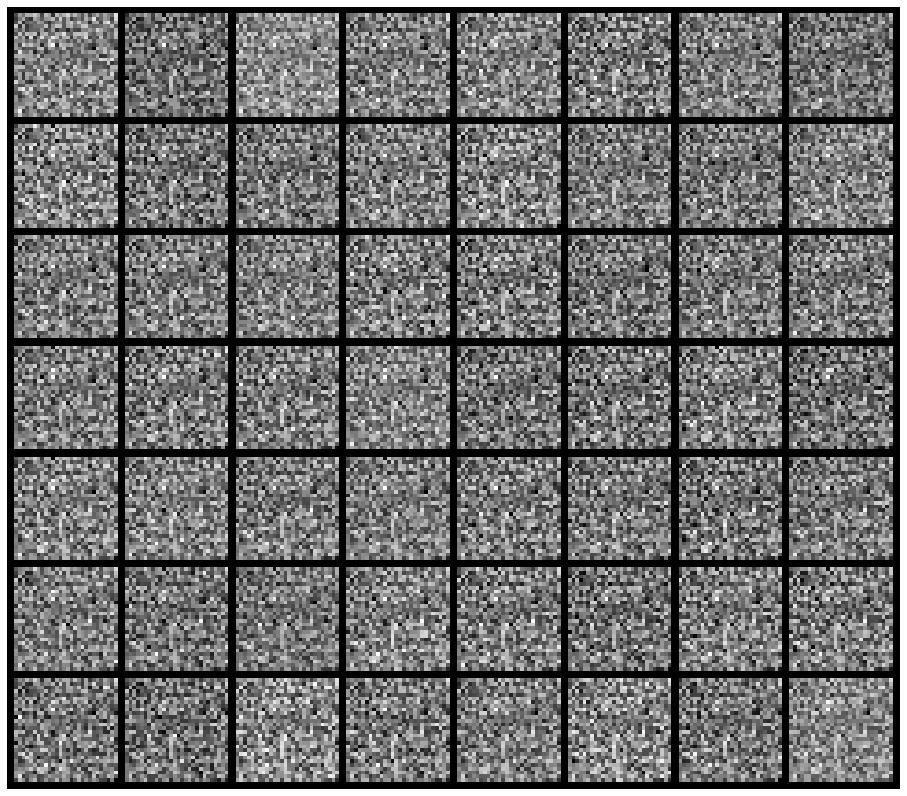

Epoch: [0/400], Batch Num: [0/1072]
Discriminator Loss: 1.4114, Generator Loss: 0.7007
D(x): 0.4839, D(G(z)): 0.4960


In [0]:

num_test_samples = 16
num_epochs = 400
num_batches = len(data_loader)

logger = Logger(model_name='vanila-GAN', data_name='MNIST')
for epoch in range(num_epochs):
    for n_batch, (real_batch,_) in enumerate(data_loader):
        N = real_batch.size(0)
        rdata = Variable(images_to_vectors(real_batch))
        fdata = generator(sample_noise(N,256)).detach()
        d_error, d_pred_real, d_pred_fake = \
              train_discriminator(Discriminator_Optimizer, rdata, fdata)
        fdata = generator(sample_noise(N,256))
        g_error = train_generator(Generator_Optimizer, fdata)
        logger.log(d_error, g_error, epoch, n_batch, num_batches)
        if (n_batch) % 1500 == 0: 
            test_images = vectors_to_images(generator(sample_noise(N,256)))
            test_images = test_images.data
            logger.log_images(test_images, num_test_samples,epoch, n_batch, num_batches);
            # Display status Logs
            logger.display_status(epoch, num_epochs, n_batch, num_batches,d_error, g_error, d_pred_real, d_pred_fake)
# logging model Checkpoints
logger.save_models(generator, discriminator, epoch)